In [2]:
!pip install pandas networkx matplotlib torch torch_geometric scikit-learn seaborn umap-learn tensorboard optuna xgboost

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.manifold import TSNE # Per la visualizzazione
import seaborn as sns # Per plot più belli
from sklearn.metrics.pairwise import cosine_similarity # Per la similarità KNN-like
from torch_geometric.transforms import RandomLinkSplit
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score 
from sklearn.preprocessing import MinMaxScaler
import os
from torch.utils.data import Dataset, DataLoader, random_split
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

from GraphSage import GraphSAGE

pd.set_option('display.max_colwidth', None)  # Mostra tutta la larghezza del contenuto della colonna
pd.set_option('display.max_columns', None)

# Verifica se CUDA è disponibile e imposta il device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


/home/kevin/Documents/uni/3anno/2_semestre/BIG DATA/graph-based-recommendation-system/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Caricamento dataset

ratings

In [2]:
ratings = pd.read_csv('../ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


generi film

In [3]:
genres = pd.read_csv('../ml-100k/u.genre', sep='|', names=['genre', 'genre_id'], encoding='latin-1')
genres.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


dataset film con colonne one-hot per i generi

In [4]:
movies_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{row["genre"]}' for index, row in genres.iterrows()]
movies = pd.read_csv('../ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
movies.head()

,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [5]:
"Ratings", ratings.columns

('Ratings',
 Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object'))

In [6]:
"Movies", movies.columns

('Movies',
 Index(['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
        'genre_unknown', 'genre_Action', 'genre_Adventure', 'genre_Animation',
        'genre_Children's', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
        'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir', 'genre_Horror',
        'genre_Musical', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi',
        'genre_Thriller', 'genre_War', 'genre_Western'],
       dtype='object'))

# Preparazione vettori

## vettori utente

per ogni utente creiamo le colonne generi che contano il numero di recensioni per quel genere

In [7]:
df_merged = pd.merge(ratings, movies, on='movieId', how='left')

# colonne generi
genre_cols = [f'genre_{row["genre"]}' for index, row in genres.iterrows()]

# 2. Melt the genre columns to have one row per user-movie-genre combination
df_genres_melted = df_merged.melt(id_vars=['userId', 'movieId'], value_vars=genre_cols,
                                  var_name='genre', value_name='is_genre')
df_genres_melted = df_genres_melted[df_genres_melted['is_genre'] == 1]

# 3. Group by userId and genre and count the occurrences
df_genre_counts = df_genres_melted.groupby(['userId', 'genre']).size().reset_index(name='review_count')

# 4. Pivot the table to get genres as columns
df_users = df_genre_counts.pivot_table(index='userId', columns='genre', values='review_count', fill_value=0)

# Reset index to make 'userId' a regular column and rename it
df_users = df_users.reset_index().rename(columns={'userId': 'user_id'})

# Display the resulting DataFrame
df_users.head()

genre,user_id,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,genre_unknown
0,1,75,42,12,25,91,25,5,107,2,1,13,13,5,44,43,52,25,6,1
1,2,10,3,1,4,16,9,0,35,1,2,2,1,4,16,4,12,3,0,0
2,3,14,4,0,0,12,10,1,22,0,2,5,2,11,5,8,21,5,0,0
3,4,8,4,0,0,4,4,1,6,0,0,1,1,5,3,6,11,2,0,0
4,5,56,33,14,29,82,9,0,27,2,1,28,12,3,19,33,19,14,2,1


normalizzazione colonne generi

In [8]:
# Calculate the sum of genre counts for each user
df_users['total_genre_reviews'] = df_users[genre_cols].sum(axis=1)

df_users_normalized = df_users[genre_cols].div(
    df_users['total_genre_reviews'], axis=0
)

# Re-add the user_id column
df_users_normalized['user_id'] = df_users['user_id']

# Reorder columns to have user_id first
df_users_normalized = df_users_normalized[['user_id'] + genre_cols]

# Display the resulting normalized DataFrame
print("Normalized df_users head:")
df_users_normalized.head()

Normalized df_users head:


genre,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208


aggiunta colonna che indica la mediana dei rating espressi dall'utente

In [9]:
user_medians = ratings.groupby('userId')['rating'].median().reset_index()
user_medians = user_medians.rename(columns={'userId': 'user_id', 'rating': 'median'})
df_users_normalized = df_users_normalized.merge(user_medians, on='user_id', how='left')

df_users_normalized.head()

,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221,4.0
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000,4.0
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000,3.0
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000,5.0
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208,3.0


scaling in base a quanto è fan verso un certo genere

In [10]:
# 1. Calcoliamo di nuovo il punteggio relativo per completezza
global_genre_avg = df_users_normalized[genre_cols].mean()
df_relative_fan_score = df_users_normalized[genre_cols].div(global_genre_avg, axis=1).fillna(0)

# 2. Applichiamo la normalizzazione Min-Max
scaler = MinMaxScaler()
df_normalized_weighted = pd.DataFrame(
    scaler.fit_transform(df_relative_fan_score),
    index=df_relative_fan_score.index,
    columns=df_relative_fan_score.columns
)

df_normalized_weighted['total'] = df_normalized_weighted[genre_cols].sum(axis=1)
df_normalized_weighted = df_normalized_weighted[genre_cols].div(
    df_normalized_weighted['total'], axis=0
)
# Aggiungi di nuovo la colonna user_id se necessario
df_normalized_weighted['user_id'] = df_users_normalized['user_id']
df_normalized_weighted['median'] = df_users_normalized['median']

print("Before fan score normalization:")
display(df_users_normalized.head(1))
print("After fan score normalization:")
display(df_normalized_weighted.head(1))
print("Mean genre scores")
pd.DataFrame(df_users_normalized[genre_cols].mean())

Before fan score normalization:


,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0.001704,0.127768,0.07155,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221,4.0


After fan score normalization:


,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,user_id,median
0,0.023031,0.096989,0.091916,0.029128,0.037343,0.08861,0.079028,0.03895,0.08131,0.019418,0.007075,0.015264,0.056097,0.015523,0.039967,0.087383,0.064322,0.066327,0.062319,1,4.0


Mean genre scores


,0
genre_unknown,0.000041
genre_Action,0.117094
genre_Adventure,0.058277
genre_Animation,0.014013
genre_Children's,0.028909
genre_Comedy,0.130530
genre_Crime,0.040604
genre_Documentary,0.003371
genre_Drama,0.198023
genre_Fantasy,0.004923


## vettore film

rimozione colonne inutili

In [11]:
df_movies = movies[['movieId'] + genre_cols].rename(columns={'movieId': 'movie_id'})
df_movies.head()

,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


aggiunta colonna mediana dei rating verso quel film

In [12]:
movie_medians = ratings.groupby('movieId')['rating'].median().reset_index()
movie_medians = movie_medians.rename(columns={'movieId': 'movie_id', 'rating': 'median'})

# 2. Unisci la mediana al DataFrame df_users
df_movies = df_movies.merge(movie_medians, on='movie_id', how='left')
df_movies.head()

,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4.0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,3.0


# Creazione grafo

In [13]:
B = nx.Graph()

nodi users

In [14]:
B.add_nodes_from(
    [
        (
            f"user_{uid}",
            {
                **{col: df_normalized_weighted.loc[df_normalized_weighted['user_id'] == uid, col].values[0] for col in df_normalized_weighted.columns if col != 'user_id'},
                'user_id': uid
            }
        )
        for uid in df_normalized_weighted['user_id']
    ],
    bipartite=0
)
print(f"Aggiunti {len(df_normalized_weighted)} nodi utente.")

Aggiunti 943 nodi utente.


In [15]:
print("Users node")
B.nodes['user_1']

Users node


{'bipartite': 0,
 'genre_unknown': 0.02303105548593626,
 'genre_Action': 0.09698907056243211,
 'genre_Adventure': 0.09191579610224337,
 'genre_Animation': 0.029127511349860562,
 "genre_Children's": 0.03734296326905202,
 'genre_Comedy': 0.08861029252217759,
 'genre_Crime': 0.07902813156938915,
 'genre_Documentary': 0.0389495791306275,
 'genre_Drama': 0.08130973332804814,
 'genre_Fantasy': 0.01941834089990704,
 'genre_Film-Noir': 0.0070748993976405515,
 'genre_Horror': 0.015263719125973444,
 'genre_Musical': 0.05609742926639812,
 'genre_Mystery': 0.015523382986844294,
 'genre_Romance': 0.03996702540596214,
 'genre_Sci-Fi': 0.08738253404958173,
 'genre_Thriller': 0.06432202708604193,
 'genre_War': 0.06632718185288017,
 'genre_Western': 0.062319326609003994,
 'median': 4.0,
 'user_id': 1}

nodi film

In [16]:
B.add_nodes_from(
    [
        (
            f"movie_{mid}",
            {
                'movie_id': mid,
                **{col: df_movies.loc[df_movies['movie_id'] == mid, col].values[0] for col in df_movies.columns if col != 'movie_id'}
            }
        )
        for mid in df_movies['movie_id']
    ],
    bipartite=1
)
print(f"Aggiunti {len(df_movies)} nodi film.")

Aggiunti 1682 nodi film.


In [17]:
print("Movies node")
B.nodes['movie_1']

Movies node


{'bipartite': 1,
 'movie_id': 1,
 'genre_unknown': 0,
 'genre_Action': 0,
 'genre_Adventure': 0,
 'genre_Animation': 1,
 "genre_Children's": 1,
 'genre_Comedy': 1,
 'genre_Crime': 0,
 'genre_Documentary': 0,
 'genre_Drama': 0,
 'genre_Fantasy': 0,
 'genre_Film-Noir': 0,
 'genre_Horror': 0,
 'genre_Musical': 0,
 'genre_Mystery': 0,
 'genre_Romance': 0,
 'genre_Sci-Fi': 0,
 'genre_Thriller': 0,
 'genre_War': 0,
 'genre_Western': 0,
 'median': 4.0}

In [18]:
for index, row in ratings.iterrows():
    user_node = f"user_{row['userId']}"
    movie_node = f"movie_{row['movieId']}"
    
    rating_value = row['rating']
    timestamp_value = row['timestamp']
    
    B.add_edge(user_node, movie_node, rating=rating_value, timestamp=timestamp_value)

print(f"\nGrafo Bipartito creato con successo!")
print(f"Numero totale di nodi nel grafo: {B.number_of_nodes()}")
print(f"Numero totale di archi nel grafo: {B.number_of_edges()}")


Grafo Bipartito creato con successo!
Numero totale di nodi nel grafo: 2625
Numero totale di archi nel grafo: 100000


Visualizzazione di un sottoinsieme: 5 utenti e 93 film correlati.


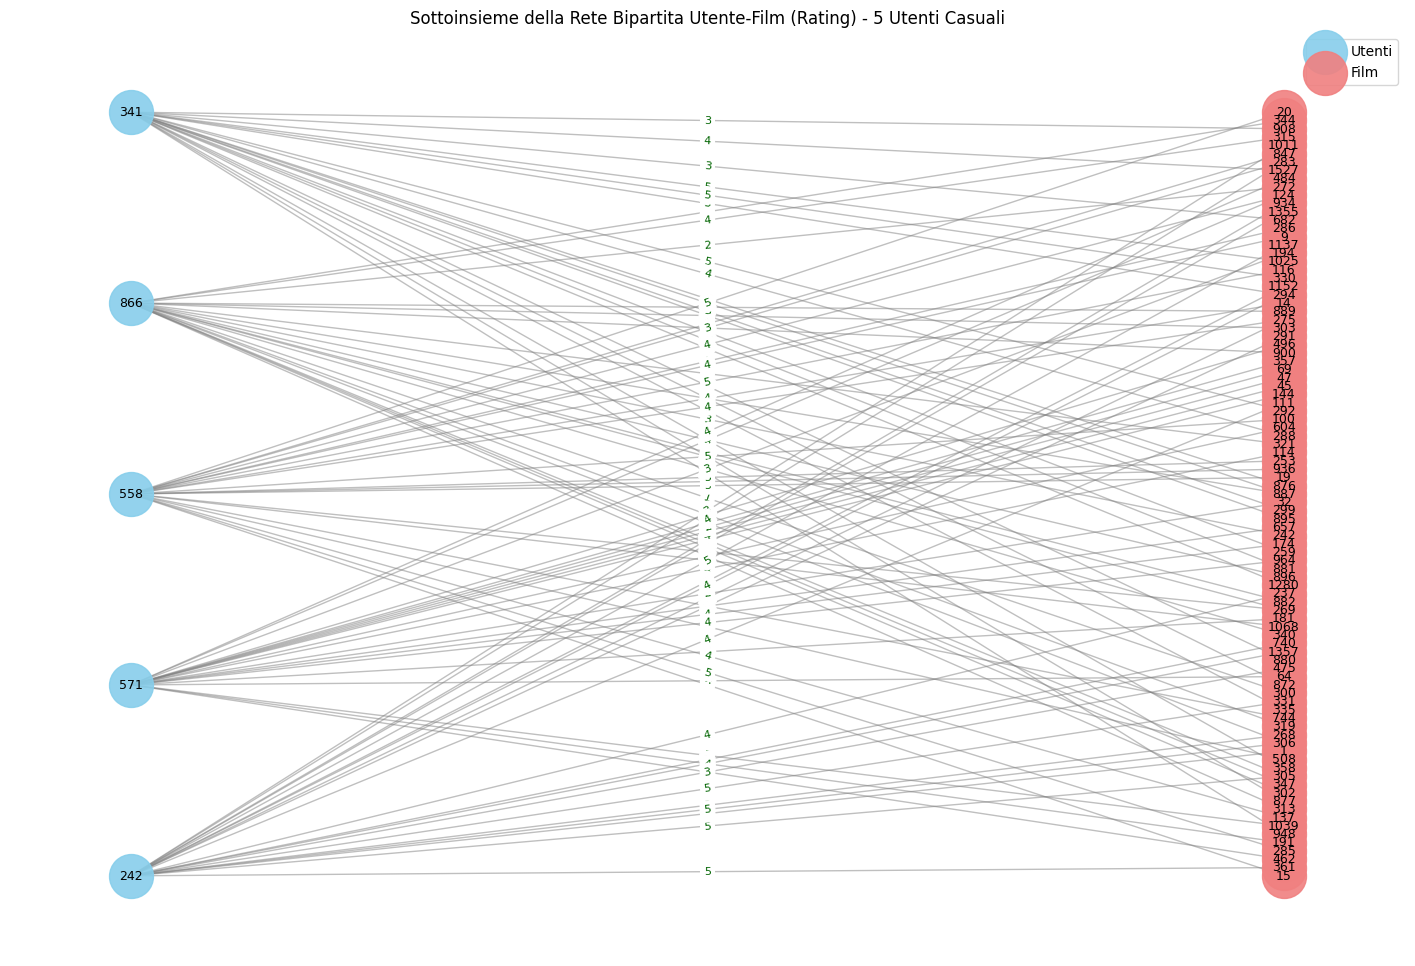

In [19]:
# Assicurati che il grafo 'B' sia già stato creato dal blocco precedente.

# Separa i nodi nei due set (utenti e film) usando l'attributo 'bipartite'
user_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
movie_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

# --- PARAMETRI PER IL SOTTOINSIEME ---
# Puoi scegliere quanti utenti visualizzare.
users_count = 5
sorted_users = df_users.loc[df_users[genre_cols].sum(axis=1).nsmallest(users_count).index]
min_user_ids = sorted_users['user_id'].tolist()
selected_user_nodes = [f"user_{uid}" for uid in min_user_ids if f"user_{uid}" in user_nodes]

# Trova tutti i film collegati a questi utenti selezionati
selected_movie_nodes = set()
for u_node in selected_user_nodes:
    for neighbor in B.neighbors(u_node):
        selected_movie_nodes.add(neighbor)

# Crea un sotto-grafo con solo i nodi selezionati e i loro archi
# Subgraph restituirà un grafo con solo i nodi e gli archi tra essi.
subgraph_nodes = set(selected_user_nodes).union(selected_movie_nodes)
B_sub = B.subgraph(subgraph_nodes)

print(f"Visualizzazione di un sottoinsieme: {len(selected_user_nodes)} utenti e {len(selected_movie_nodes)} film correlati.")

plt.figure(figsize=(18, 12)) # Aumenta ancora la dimensione per una migliore leggibilità

# Utilizza il layout specifico per grafi bipartiti sul sotto-grafo.
# È importante passare i nodi del sotto-grafo che appartengono al set degli utenti.
# Filtrali dal set originale di user_nodes.
sub_user_nodes_for_layout = {n for n in selected_user_nodes if n in B_sub.nodes()}
pos_sub = nx.bipartite_layout(B_sub, sub_user_nodes_for_layout)

# --- Disegna i nodi del sotto-grafo ---
# Nodi Utente: colorati di azzurro
nx.draw_networkx_nodes(B_sub, pos_sub, nodelist=list(sub_user_nodes_for_layout), node_color='skyblue', node_size=1000, label='Utenti', alpha=0.9)
# Nodi Film: colorati di rosso corallo
nx.draw_networkx_nodes(B_sub, pos_sub, nodelist=list(selected_movie_nodes), node_color='lightcoral', node_size=1000, label='Film', alpha=0.9)

# --- Disegna gli archi del sotto-grafo ---
nx.draw_networkx_edges(B_sub, pos_sub, width=1.0, alpha=0.5, edge_color='gray')

# --- Aggiungi le etichette ai nodi del sotto-grafo ---
# Modifica qui per stampare l'ID utente nei nodi bipartite 0 e l'ID film nei nodi bipartite 1
labels = {}
for node, data in B_sub.nodes(data=True):
    if data['bipartite'] == 0:  # Nodo utente
        labels[node] = node.replace('user_', '') # Mostra solo l'ID numerico dell'utente
    elif data['bipartite'] == 1: # Nodo film
        labels[node] = data['movie_id']  # Mostra l'ID del film

nx.draw_networkx_labels(B_sub, pos_sub, labels, font_size=9, font_color='black')

# --- Aggiungi etichette per i rating sugli archi ---
edge_labels = nx.get_edge_attributes(B_sub, 'rating')
nx.draw_networkx_edge_labels(B_sub, pos_sub, edge_labels=edge_labels, font_size=8, font_color='darkgreen')

# --- Aggiungi una legenda ---
plt.title(f"Sottoinsieme della Rete Bipartita Utente-Film (Rating) - {users_count} Utenti Casuali")
plt.legend(scatterpoints=1)
plt.axis('off') # Nasconde gli assi del grafico
plt.show()

# GrapSAGE

conversione in pytorch geometric

In [20]:
# Mapping dei nodi
node_to_idx = {node: i for i, node in enumerate(B.nodes())}
idx_to_node = {i: node for node, i in node_to_idx.items()}
num_nodes = B.number_of_nodes()

user_keys = None
item_keys = None

for node in B.nodes():
    data = B.nodes[node]
    if data['bipartite'] == 0 and user_keys is None:
        user_keys = [k for k in data if k not in ('bipartite', 'user_id')]
    elif data['bipartite'] == 1 and item_keys is None:
        item_keys = [k for k in data if k not in ('bipartite', 'movie_id')]
    if user_keys and item_keys:
        break

# Costruisci le feature dinamicamente
features = []
for node in B.nodes():
    data = B.nodes[node]
    keys = user_keys if data['bipartite'] == 0 else item_keys
    feat = [float(data.get(k, 0.0)) for k in keys]  # fallback a 0.0 se mancante
    features.append(torch.tensor(feat, dtype=torch.float))


x = torch.stack(features)

edge_index_list = []
for u, v in B.edges():
    edge_index_list.append([node_to_idx[u], node_to_idx[v]])
    edge_index_list.append([node_to_idx[v], node_to_idx[u]])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
edge_index = edge_index.to(device)


print(f"Numero totale di nodi: {num_nodes}")
print(f"Numero totale di archi (bidirezionali): {edge_index.size(1)}")

# Stampa info
user_count = sum(1 for node in B.nodes if B.nodes[node]['bipartite'] == 0)
item_count = num_nodes - user_count
print(f"Nodi utente: {user_count}, Nodi item (film): {item_count}")

# Stampa un solo nodo utente
user_node = next(node for node in B.nodes if B.nodes[node]['bipartite'] == 0)
user_idx = node_to_idx[user_node]
print("\nNodo utente:")
print(f" Nodo: {user_node}")
print(f" Feature: {x[user_idx].cpu().numpy()}")

# Stampa un solo nodo item (film)
item_node = next(node for node in B.nodes if B.nodes[node]['bipartite'] == 1)
item_idx = node_to_idx[item_node]
print("\nNodo film:")
print(f" Nodo: {item_node}")
print(f" Feature: {x[item_idx].cpu().numpy()}")

Numero totale di nodi: 2625
Numero totale di archi (bidirezionali): 200000
Nodi utente: 943, Nodi item (film): 1682

Nodo utente:
 Nodo: user_1
 Feature: [0.02303106 0.09698907 0.09191579 0.02912751 0.03734296 0.08861029
 0.07902813 0.03894958 0.08130974 0.01941834 0.0070749  0.01526372
 0.05609743 0.01552338 0.03996703 0.08738253 0.06432202 0.06632718
 0.06231933 4.        ]

Nodo film:
 Nodo: movie_1
 Feature: [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4.]


split dataset in train e test

In [21]:
# Assumiamo che B, x, edge_index, node_to_idx siano già stati creati
network = Data(x=x, edge_index=edge_index)

# Suddividiamo gli archi in 80% training, 10% validazione, 10% test
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=True,
    num_val=0.2,
    num_test=0.1,
    split_labels=True
)

train_data, val_data, test_data = transform(network)

print("Train Data:\n", train_data)
print("\nValidation Data:\n", val_data)
print("\nTest Data:\n", test_data)

Train Data:
 Data(x=[2625, 20], edge_index=[2, 140000], pos_edge_label=[70000], pos_edge_label_index=[2, 70000], neg_edge_label=[70000], neg_edge_label_index=[2, 70000])

Validation Data:
 Data(x=[2625, 20], edge_index=[2, 140000], pos_edge_label=[20000], pos_edge_label_index=[2, 20000], neg_edge_label=[20000], neg_edge_label_index=[2, 20000])

Test Data:
 Data(x=[2625, 20], edge_index=[2, 180000], pos_edge_label=[10000], pos_edge_label_index=[2, 10000], neg_edge_label=[10000], neg_edge_label_index=[2, 10000])


## Version 1: Link prediction

In [138]:
def get_scores(scores, labels):
    auc = roc_auc_score(labels.detach().cpu().numpy(), scores.detach().cpu().numpy())
    ap = average_precision_score(labels.detach().cpu().numpy(), scores.detach().cpu().numpy())

    return {
        'accuracy': auc,
        'precision': ap
    }

def process(model, data):
    node_embeddings = model(data.x, data.edge_index)
    
    pos_edge_embedding = node_embeddings[data.pos_edge_label_index[0]] * node_embeddings[data.pos_edge_label_index[1]]
    neg_edge_embedding = node_embeddings[data.neg_edge_label_index[0]] * node_embeddings[data.neg_edge_label_index[1]]

    pos_scores = pos_edge_embedding.sum(dim=1)
    neg_scores = neg_edge_embedding.sum(dim=1)

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])

    loss = F.binary_cross_entropy_with_logits(scores, labels)

    return loss, scores, labels

def train(model, optimizer):
    model.train()
    optimizer.zero_grad()

    loss, scores, labels = process(model, train_data)

    loss.backward()

    found_gradients = False
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm > 1e-9: 
                found_gradients = True

    optimizer.step()

    return {
        'loss': loss.item(),
        'scores': get_scores(scores, labels)        
    }

@torch.no_grad() 
def test(model, data):
    model.eval() 
    
    loss, scores, labels = process(model, data)
    
    return {
        'loss': loss.item(),
        'scores': get_scores(scores, labels)        
    }

In [49]:
# 1) Definisci l’objective che include il loop epoche
def objective(trial):
    # 1.a) suggerisci gli iperparametri da tunare
    hidden_channels = trial.suggest_int('hidden_channels', 16, 128, step=16)
    out_channels = trial.suggest_int('out_channels', 16, 128, step=16)
    num_layers      = trial.suggest_int('num_layers', 1, 5)
    dropout         = trial.suggest_float('dropout', 0.0, 0.8)
    # lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    lr = 0.001

    # 1.b) (ri)istanzia il modello con i parametri suggeriti
    model = GraphSAGE(
        in_channels=network.x.size(1),
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        num_layers=num_layers,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    exp = '12'
    name = f'exp_{exp}-{num_layers}_layers-{hidden_channels}_inSize-{out_channels}_outSize-{dropout}_dropout-lr_{lr}'
    writer = SummaryWriter(f'../runs/{name}')
    print(f""
      f"num_layers={num_layers}, "
      f"hidden_channels={hidden_channels}, "
      f"out_channels={out_channels}, "
      f"dropout={dropout:.2f}, "
      f"learning_rate={lr:.1e}")

    best_acc = 0.0
    epochs   = 500

    for epoch in range(1, epochs + 1):
        train_res = train(model, optimizer)
        val_res  = test(model, val_data)

        # report a Optuna per il pruning
        trial.report(val_res['scores']['accuracy'], epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        combined_score = 0.5 * val_res['scores']['accuracy'] + 0.5 * val_res['scores']['precision']
        best_acc = max(best_acc, combined_score)

        # log e stampa ogni 10 epoche (o la prima)
        if epoch == 1 or epoch % 10 == 0:
            writer.add_scalar('loss/train', train_res['loss'], epoch)
            writer.add_scalar('auc/train',  train_res['scores']['accuracy'], epoch)
            writer.add_scalar('ap/train',   train_res['scores']['precision'], epoch)
            writer.add_scalar('loss/test',  val_res['loss'], epoch)
            writer.add_scalar('auc/test',   val_res['scores']['accuracy'], epoch)
            writer.add_scalar('ap/test',    val_res['scores']['precision'], epoch)
            
    print(f"Epoch {epoch:03d} | "
            f"lr={lr:.1e} hid={hidden_channels} lay={num_layers} drop={dropout:.2f} | "
            f"Train Acc={train_res['scores']['accuracy']:.4f} "
            f"Test Acc={val_res['scores']['accuracy']:.4f}\n\n")

    torch.save(model.state_dict(), f'../weights/{name}.pth')

    return best_acc

In [50]:
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(),
    pruner=SuccessiveHalvingPruner(min_resource=50)
)
study.optimize(objective, n_trials=10, timeout=3600)

print("Best accuracy:", study.best_value)
print("Best params:", study.best_params)

[I 2025-07-06 18:17:42,983] A new study created in memory with name: no-name-e4dc7eec-d97d-49e8-bf74-afa74f1b4270


num_layers=2, hidden_channels=16, out_channels=112, dropout=0.42, learning_rate=1.0e-03


[I 2025-07-06 18:21:27,367] Trial 0 finished with value: 0.7551948812956737 and parameters: {'hidden_channels': 16, 'out_channels': 112, 'num_layers': 2, 'dropout': 0.41958975221212297}. Best is trial 0 with value: 0.7551948812956737.


Epoch 500 | lr=1.0e-03 hid=16 lay=2 drop=0.42 | Train Acc=0.7301 Test Acc=0.7767


num_layers=4, hidden_channels=64, out_channels=16, dropout=0.00, learning_rate=1.0e-03


[I 2025-07-06 18:24:20,842] Trial 1 finished with value: 0.8485165778512589 and parameters: {'hidden_channels': 64, 'out_channels': 16, 'num_layers': 4, 'dropout': 4.806245110247076e-05}. Best is trial 1 with value: 0.8485165778512589.


Epoch 500 | lr=1.0e-03 hid=64 lay=4 drop=0.00 | Train Acc=0.8680 Test Acc=0.8549


num_layers=5, hidden_channels=48, out_channels=64, dropout=0.42, learning_rate=1.0e-03


[I 2025-07-06 18:24:46,055] Trial 2 pruned. 


num_layers=2, hidden_channels=32, out_channels=32, dropout=0.14, learning_rate=1.0e-03


[I 2025-07-06 18:24:59,655] Trial 3 pruned. 


num_layers=2, hidden_channels=48, out_channels=112, dropout=0.24, learning_rate=1.0e-03


[I 2025-07-06 18:25:25,177] Trial 4 pruned. 


num_layers=2, hidden_channels=64, out_channels=64, dropout=0.41, learning_rate=1.0e-03


[I 2025-07-06 18:25:45,969] Trial 5 pruned. 


num_layers=4, hidden_channels=128, out_channels=96, dropout=0.59, learning_rate=1.0e-03


[I 2025-07-06 18:26:25,917] Trial 6 pruned. 


num_layers=4, hidden_channels=64, out_channels=96, dropout=0.45, learning_rate=1.0e-03


[I 2025-07-06 18:26:55,721] Trial 7 pruned. 


num_layers=4, hidden_channels=16, out_channels=48, dropout=0.10, learning_rate=1.0e-03


[I 2025-07-06 18:27:58,987] Trial 8 pruned. 


num_layers=2, hidden_channels=96, out_channels=64, dropout=0.39, learning_rate=1.0e-03


[I 2025-07-06 18:28:14,664] Trial 9 pruned. 


Best accuracy: 0.8485165778512589
Best params: {'hidden_channels': 64, 'out_channels': 16, 'num_layers': 4, 'dropout': 4.806245110247076e-05}


In [86]:
best_graphsage_params = study.best_params
best_graphsage_params['lr'] = 0.001
best_graphsage_params

{'hidden_channels': 64,
 'out_channels': 16,
 'num_layers': 4,
 'dropout': 4.806245110247076e-05,
 'lr': 0.001}

In [135]:
best_graphsage_params = {
    'hidden_channels': 64,
    'out_channels': 16,
    'num_layers': 4,
    'dropout': 4.806245110247076e-05,
    'lr': 0.001
}

In [139]:
model = GraphSAGE(
    in_channels=network.x.size(1),
    hidden_channels=best_graphsage_params['hidden_channels'],
    out_channels=best_graphsage_params['out_channels'],
    num_layers=best_graphsage_params['num_layers'],
    dropout=best_graphsage_params['dropout'],
)

weights = f"exp_12-{best_graphsage_params['num_layers']}_layers-{best_graphsage_params['hidden_channels']}_inSize-{best_graphsage_params['out_channels']}_outSize-{best_graphsage_params['dropout']}_dropout-lr_{best_graphsage_params['lr']}.pth"
model.load_state_dict(torch.load(f'../weights/{weights}'))
model.eval()
print(f"Caricato i pesi {weights}")

Caricato i pesi exp_12-4_layers-64_inSize-16_outSize-4.806245110247076e-05_dropout-lr_0.001.pth


/tmp/ipykernel_3931/2107459765.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../weights/{weights}'))


In [140]:
test(model, test_data)

{'loss': 0.5584937334060669,
 'scores': {'accuracy': 0.855928615, 'precision': 0.8421439132963242}}

## V2: MLP over link prediction
### Pytorch network

In [58]:
with torch.no_grad():
    node_embeddings = model(network.x, network.edge_index)

In [104]:
# --- 1. Custom Dataset class ---
class RatingDataset(Dataset):
    def __init__(self, ratings_df, node_emb):
        self.user_ids = torch.tensor(ratings_df['userId'].values, dtype=torch.long)
        self.movie_ids = torch.tensor(ratings_df['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings_df['rating'].values, dtype=torch.float32)
        self.embeddings = node_emb  # full embedding matrix

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user_emb = self.embeddings[self.user_ids[idx]]
        movie_emb = self.embeddings[self.movie_ids[idx]]
        x = torch.cat([user_emb, movie_emb], dim=0)  # input vector
        # x = user_emb * movie_emb  # element-wise product
        y = self.ratings[idx]
        return x, y

In [105]:
# --- 3. Prepare Dataset and DataLoaders ---
dataset = RatingDataset(ratings, node_embeddings)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

In [100]:
# --- 2. Regressor neural network ---
class MLP(nn.Module):
    def __init__(self, input_dim: int, num_hidden: int, hidden_dim: int, dropout: float = 0.2):
        super().__init__()
        layers = []
        
        # Primo hidden layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Altri hidden layers (tutti hidden_dim → hidden_dim)
        for _ in range(num_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, 1))
        
        # Combina tutto in un Sequential
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        rating = self.net(x).squeeze()
        return rating

In [29]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import optuna

def evaluate(model, loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * len(y)
    return np.sqrt(total_loss / len(loader.dataset))

In [103]:
def objective(trial):
    # Hyperparametri suggeriti da Optuna
    num_hidden = trial.suggest_int('num_hidden', 1, 5)
    hidden_dim = trial.suggest_int('hidden_channels', 16, 128, step=16)
    dropout = trial.suggest_float('dropout', 0.0, 0.8)
    lr = 0.001

    # Istanzia modello (assumendo MLP definito altrove)
    mlp_model = MLP(
        input_dim=best_graphsage_params['out_channels']*2,
        num_hidden=num_hidden,
        hidden_dim=hidden_dim,
        dropout=dropout
    )

    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    name = f'REGRESSOR-exp_1-{num_hidden}_layers-{hidden_dim}_hiddenSize-{dropout:.2f}_dropout-lr_{lr}'
    writer = SummaryWriter(f'../runs/{name}')

    print(f"num_hidden={num_hidden}, hidden_dim={hidden_dim}, dropout={dropout:.2f}, learning_rate={lr:.1e}")

    best_rmse = float('inf')
    epochs = 50

    for epoch in range(1, epochs + 1):
        epoch_losses = {'train': 0.0, 'val': 0.0}
        epoch_sizes = {'train': 0, 'val': 0}
        epoch_rmses = {'train': 0.0, 'val': 0.0}

        for mode in ['train', 'val']:
            if mode == 'train':
                mlp_model.train()
                loader = train_loader
            else:
                mlp_model.eval()
                loader = val_loader

            for x, y in loader:
                if mode == 'train':
                    optimizer.zero_grad()
                    preds = mlp_model(x)
                    loss = criterion(preds, y)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        preds = mlp_model(x)
                        loss = criterion(preds, y)

                epoch_losses[mode] += loss.item() * len(y)
                epoch_sizes[mode] += len(y)

        # Calcolo e log loss e RMSE a fine epoca per train e val
        for mode in ['train', 'val']:
            avg_loss = epoch_losses[mode] / epoch_sizes[mode]
            rmse = np.sqrt(avg_loss)
            epoch_rmses[mode] = rmse

            writer.add_scalar(f'Loss/{mode}', avg_loss, epoch)
            writer.add_scalar(f'RMSE/{mode}', rmse, epoch)

        # print(f"Epoch {epoch:03d} | Train RMSE: {epoch_rmses['train']:.4f} | Val RMSE: {epoch_rmses['val']:.4f}")

        # Report a Optuna e pruning solo a fine epoca
        trial.report(epoch_rmses['val'], epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Salvataggio modello migliore
        if epoch_rmses['val'] < best_rmse:
            best_rmse = epoch_rmses['val']
            torch.save(mlp_model.state_dict(), f'../weights/{name}.pth')

    print(f"\nBest Val RMSE: {best_rmse:.4f} — Model saved as {name}.pth\n")
    return best_rmse

In [ ]:
mlp_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(),
    pruner=SuccessiveHalvingPruner(min_resource=5)
)

mlp_study.optimize(objective, n_trials=10, timeout=3600)

print("Best RMSE:", mlp_study.best_value)
print("Best params:", mlp_study.best_params)

In [129]:
mlp_best_params = mlp_study.best_params
mlp_best_params['lr'] = 0.001
mlp_best_params['exp'] = '1'
mlp_best_params

{'num_hidden': 3,
 'hidden_channels': 80,
 'dropout': 0.029798727971475536,
 'lr': 0.001,
 'exp': '1'}

In [61]:
mlp_best_params = {
    'num_hidden': 4,
    'hidden_channels': 80,
    'dropout': 0.05,
    'lr': 0.001,
    'exp': '0'
}
mlp_best_params

{'num_hidden': 4,
 'hidden_channels': 80,
 'dropout': 0.05,
 'lr': 0.001,
 'exp': '0'}

In [68]:
mlp_model = MLP(
    input_dim=best_graphsage_params['out_channels']*2,
    num_hidden=mlp_best_params['num_hidden'],
    hidden_dim=mlp_best_params['hidden_channels'],
    dropout=mlp_best_params['dropout']
)

weights = f'REGRESSOR_EN-exp_{mlp_best_params["exp"]}-{mlp_best_params["num_hidden"]}_layers-{mlp_best_params["hidden_channels"]}_hiddenSize-{mlp_best_params["dropout"]:.2f}_dropout-lr_{mlp_best_params["lr"]}.pth'
mlp_model.load_state_dict(torch.load(f'../weights/{weights}'))
mlp_model.eval()
print(f"Caricato i pesi {weights}")

# --- 5. Final evaluation on test set ---
test_rmse = evaluate(mlp_model, test_loader)
print(f"\nTest RMSE: {test_rmse:.4f}")

Caricato i pesi REGRESSOR_EN-exp_0-4_layers-80_hiddenSize-0.05_dropout-lr_0.001.pth

Test RMSE: 1.0081


/tmp/ipykernel_3931/3815816817.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(f'../weights/{weights}'))


In [69]:
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=mlp_best_params['lr'])
criterion = nn.MSELoss()

name = f'REGRESSOR_EN4-exp_{mlp_best_params["exp"]}-{mlp_best_params["num_hidden"]}_layers-{mlp_best_params["hidden_channels"]}_hiddenSize-{mlp_best_params["dropout"]:.2f}_dropout-lr_{mlp_best_params["lr"]}'
writer = SummaryWriter(f'../runs/{name}')

best_rmse = 1.0628
epochs = 100

for epoch in range(1, epochs + 1):
    epoch_losses = {'train': 0.0, 'val': 0.0}
    epoch_sizes = {'train': 0, 'val': 0}
    epoch_rmses = {'train': 0.0, 'val': 0.0}

    for mode in ['train', 'val']:
        if mode == 'train':
            mlp_model.train()
            loader = train_loader
        else:
            mlp_model.eval()
            loader = val_loader

        for x, y in loader:
            if mode == 'train':
                optimizer.zero_grad()
                preds = mlp_model(x)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()
            else:
                with torch.no_grad():
                    preds = mlp_model(x)
                    loss = criterion(preds, y)

            epoch_losses[mode] += loss.item() * len(y)
            epoch_sizes[mode] += len(y)

    # Calcolo e log loss e RMSE a fine epoca per train e val
    for mode in ['train', 'val']:
        avg_loss = epoch_losses[mode] / epoch_sizes[mode]
        rmse = np.sqrt(avg_loss)
        epoch_rmses[mode] = rmse

        writer.add_scalar(f'Loss/{mode}', avg_loss, epoch)
        writer.add_scalar(f'RMSE/{mode}', rmse, epoch)

    print(f"Epoch {epoch:03d} | Train RMSE: {epoch_rmses['train']:.4f} | Val RMSE: {epoch_rmses['val']:.4f}")

    # Salvataggio modello migliore
    if epoch_rmses['val'] < best_rmse:
        best_rmse = epoch_rmses['val']
        torch.save(mlp_model.state_dict(), f'../weights/{name}.pth')

Epoch 001 | Train RMSE: 1.0274 | Val RMSE: 1.0146
Epoch 002 | Train RMSE: 1.0264 | Val RMSE: 1.0123
Epoch 003 | Train RMSE: 1.0263 | Val RMSE: 1.0172
Epoch 004 | Train RMSE: 1.0266 | Val RMSE: 1.0194
Epoch 005 | Train RMSE: 1.0265 | Val RMSE: 1.0189
Epoch 006 | Train RMSE: 1.0262 | Val RMSE: 1.0200
Epoch 007 | Train RMSE: 1.0256 | Val RMSE: 1.0183
Epoch 008 | Train RMSE: 1.0255 | Val RMSE: 1.0205
Epoch 009 | Train RMSE: 1.0243 | Val RMSE: 1.0180
Epoch 010 | Train RMSE: 1.0237 | Val RMSE: 1.0205
Epoch 011 | Train RMSE: 1.0241 | Val RMSE: 1.0208
Epoch 012 | Train RMSE: 1.0231 | Val RMSE: 1.0210
Epoch 013 | Train RMSE: 1.0224 | Val RMSE: 1.0268
Epoch 014 | Train RMSE: 1.0235 | Val RMSE: 1.0266
Epoch 015 | Train RMSE: 1.0232 | Val RMSE: 1.0224
Epoch 016 | Train RMSE: 1.0231 | Val RMSE: 1.0253
Epoch 017 | Train RMSE: 1.0212 | Val RMSE: 1.0268
Epoch 018 | Train RMSE: 1.0210 | Val RMSE: 1.0235
Epoch 019 | Train RMSE: 1.0220 | Val RMSE: 1.0252
Epoch 020 | Train RMSE: 1.0206 | Val RMSE: 1.0251


In [82]:
def evaluate_r2(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in loader:
            preds = model(x)
            y_true.append(y)
            y_pred.append(preds)

    # Concatena tutti i batch in un singolo tensore
    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

    # Calcolo R²
    ss_res = np.sum((y_true - y_pred) ** 2)       # somma dei residui quadratici
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # somma totale della varianza
    r2 = 1 - (ss_res / ss_tot)

    return r2

In [84]:
mlp_model = MLP(
    input_dim=best_graphsage_params['out_channels']*2,
    num_hidden=mlp_best_params['num_hidden'],
    hidden_dim=mlp_best_params['hidden_channels'],
    dropout=mlp_best_params['dropout']
)

weights = f'REGRESSOR_EN-exp_{mlp_best_params["exp"]}-{mlp_best_params["num_hidden"]}_layers-{mlp_best_params["hidden_channels"]}_hiddenSize-{mlp_best_params["dropout"]:.2f}_dropout-lr_{mlp_best_params["lr"]}.pth'
mlp_model.load_state_dict(torch.load(f'../weights/{weights}'))
mlp_model.eval()
print(f"Caricato i pesi {weights}")

# --- 5. Final evaluation on test set ---
test_rmse = evaluate(mlp_model, test_loader)
test_r2 = evaluate_r2(mlp_model, test_loader)
print(f"\nTest RMSE: {test_rmse:.4f}")
print(f"\nTest R^2: {test_r2:.4f}")

/tmp/ipykernel_3931/1395106583.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(f'../weights/{weights}'))


Caricato i pesi REGRESSOR_EN-exp_0-4_layers-80_hiddenSize-0.05_dropout-lr_0.001.pth

Test RMSE: 1.0081

Test R^2: 0.1983


### XGBOOST

In [124]:
import numpy as np
import torch
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# --- 1. Costruisci X e y direttamente ---
user_ids = torch.tensor(ratings['userId'].values, dtype=torch.long)
movie_ids = torch.tensor(ratings['movieId'].values, dtype=torch.long)
ratings_vals = ratings['rating'].values.astype(np.float32)

user_embs = node_embeddings[user_ids]     # shape: (N, emb_dim)
movie_embs = node_embeddings[movie_ids]   # shape: (N, emb_dim)

X_tensor = torch.cat([user_embs, movie_embs], dim=1)  # concat embeddings
X = X_tensor.numpy()
y = ratings_vals

# --- Assumendo che X e y siano già definiti ---

# Split train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'random_state': 42,
        'objective': 'reg:squarederror',
        'verbosity': 0
    }

    model = XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    val_preds = model.predict(X_val)
    val_rmse = mean_squared_error(y_val, val_preds, squared=False)
    return val_rmse

# Crea lo studio Optuna e lancia l'ottimizzazione
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # 20 tentativi, più veloce

print("Migliori parametri:", study.best_params)
print(f"Miglior RMSE sulla validation: {study.best_value:.4f}")

# Allena modello finale con i parametri ottimizzati
best_params = study.best_params
best_params.update({'random_state': 42, 'objective': 'reg:squarederror'})
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Valutazione finale sul test set
test_preds = model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
test_r2 = r2_score(y_test, test_preds)

print(f"Test RMSE: {test_rmse:.4f} | Test R²: {test_r2:.4f}")

[I 2025-07-07 17:04:59,499] A new study created in memory with name: no-name-a4cd6f7e-bcce-4559-8428-93af833bab51
[I 2025-07-07 17:05:00,137] Trial 0 finished with value: 1.100955605506897 and parameters: {'n_estimators': 97, 'max_depth': 3, 'learning_rate': 0.020789305497925955}. Best is trial 0 with value: 1.100955605506897.
[I 2025-07-07 17:05:00,860] Trial 1 finished with value: 1.0686092376708984 and parameters: {'n_estimators': 98, 'max_depth': 4, 'learning_rate': 0.046866576043809546}. Best is trial 1 with value: 1.0686092376708984.
[I 2025-07-07 17:05:01,692] Trial 2 finished with value: 1.0610383749008179 and parameters: {'n_estimators': 95, 'max_depth': 3, 'learning_rate': 0.10489150251286865}. Best is trial 2 with value: 1.0610383749008179.
[I 2025-07-07 17:05:02,908] Trial 3 finished with value: 1.0106900930404663 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.06713978500557619}. Best is trial 3 with value: 1.0106900930404663.
[I 2025-07-07 17:05:0

Migliori parametri: {'n_estimators': 149, 'max_depth': 6, 'learning_rate': 0.291961504212549}
Miglior RMSE sulla validation: 0.9665
Test RMSE: 0.9596 | Test R²: 0.2662


# Valutazione

In [141]:
with torch.no_grad():
    node_embeddings = model(network.x, network.edge_index)


def get_node_id_field(node_id):
    """
    Recupera il campo ID specifico (user_id o movie_id) per un nodo dal grafo NetworkX B.
    """
    node_attrs = B.nodes[node_id]
    if node_attrs['bipartite'] == 0: # È un utente
        return node_attrs.get('user_id', node_id)
    else: # È un film (o item)
        return node_attrs.get('movie_id', node_id)

In [142]:
# --- ESEMPIO 1: Raccomandare FILM a un UTENTE ---
print("===== ESEMPIO 1: Raccomandare FILM a un UTENTE =====")

start_user_original_id = next(node for node, attrs in B.nodes(data=True) if attrs['bipartite'] == 0)
start_user_idx = node_to_idx[start_user_original_id]
start_user_embedding = node_embeddings[start_user_idx]

# Stampa solo l'ID dell'utente di partenza
print(f"Utente di Partenza: '{get_node_id_field(start_user_original_id)}'")

# Trova tutti i film a cui l'utente è già collegato (ID originali)
already_watched_movies_ids = set(B.neighbors(start_user_original_id))

# Candidati per la raccomandazione: tutti i nodi di TIPO FILM che l'utente NON ha ancora visto
candidate_movie_original_ids = [
    node_id for node_id, attrs in B.nodes(data=True)
    if attrs['bipartite'] == 1 and node_id not in already_watched_movies_ids
]

# Converti gli ID originali dei film candidati nei loro indici PyTorch Geometric
candidate_movie_indices = [node_to_idx[oid] for oid in candidate_movie_original_ids]
candidate_movie_embeddings = node_embeddings[candidate_movie_indices]

# Calcola i punteggi di connessione tra l'utente e i film candidati
reco_scores = (start_user_embedding * candidate_movie_embeddings).sum(dim=1)

# Ordina i candidati e prendi i Top-K
top_k = 5
sorted_reco_scores, sorted_reco_indices = torch.sort(reco_scores, descending=True)

recommended_movie_indices = [candidate_movie_indices[i] for i in sorted_reco_indices[:top_k]]
recommended_con_scores = sorted_reco_scores[:top_k]

print(f"\nTop {top_k} raccomandazioni di FILM per l'utente '{get_node_id_field(start_user_original_id)}':")
for movie_idx, score in zip(recommended_movie_indices, recommended_con_scores):
    movie_original_id = idx_to_node[movie_idx] # Converti l'indice PyG in ID originale

    # Stampa solo l'ID del film raccomandato
    print(f"  Film ID: '{get_node_id_field(movie_original_id)}', Probabilità: {torch.sigmoid(score).item():.4f}")

===== ESEMPIO 1: Raccomandare FILM a un UTENTE =====
Utente di Partenza: '1'

Top 5 raccomandazioni di FILM per l'utente '1':
  Film ID: '423', Probabilità: 0.9757
  Film ID: '405', Probabilità: 0.9743
  Film ID: '385', Probabilità: 0.9714
  Film ID: '515', Probabilità: 0.9706
  Film ID: '429', Probabilità: 0.9694


In [42]:
display(df_users[df_users['user_id']==1])
display(movies[movies['movieId'].isin([385, 423, 405])])

genre,user_id,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,genre_unknown,total_genre_reviews
0,1,75,42,12,25,91,25,5,107,2,1,13,13,5,44,43,52,25,6,1,587


,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
384,385,True Lies (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?True%20Lies%20(1994),0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
404,405,Mission: Impossible (1996),22-May-1996,NaN,http://us.imdb.com/M/title-exact?Mission:%20Impossible%20(1996),0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
422,423,E.T. the Extra-Terrestrial (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?E%2ET%2E%20the%20Extra-Terrestrial%20%281982%29,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0


In [49]:
node_embeddings[0]

tensor([-0.3630, -0.3668, -0.0941, -0.3549, -0.3783, -0.1754, -0.2786,  0.3021,
         0.3497, -0.2491, -0.4183,  0.4264, -0.3336, -0.5523, -0.3067, -0.0870,
        -0.1393,  0.4845, -0.4164,  0.3446, -0.0437, -0.3380,  0.2569, -0.2489,
        -0.1820, -0.3844, -0.2895, -0.3393,  0.3746,  0.0738,  0.0022, -0.3069])

In [143]:
print("===== ESEMPIO 2: Raccomandare FILM SIMILI a un FILM dato =====")

# Seleziona un film di partenza (nodo bipartite=1)
start_movie_original_id = next(node for node, attrs in B.nodes(data=True) if attrs['bipartite'] == 1)
start_movie_idx = node_to_idx[start_movie_original_id]
start_movie_embedding = node_embeddings[start_movie_idx].unsqueeze(0)  # shape: [1, dim]

# Stampa solo l'ID del film di partenza
print(f"\nFilm di Partenza Selezionato (bipartite=1): '{get_node_id_field(start_movie_original_id)}'")

# Candidati per la raccomandazione: tutti i film eccetto quello di partenza
candidate_similar_movie_ids = [
    node_id for node_id, attrs in B.nodes(data=True)
    if attrs['bipartite'] == 1 and node_id != start_movie_original_id
]

if not candidate_similar_movie_ids:
    print(f"Non ci sono altri film nel grafo simili a '{get_node_id_field(start_movie_original_id)}'.")
else:
    # Ottieni indici e embedding dei candidati
    candidate_similar_movie_indices = [node_to_idx[oid] for oid in candidate_similar_movie_ids]
    candidate_similar_movie_embeddings = node_embeddings[candidate_similar_movie_indices]  # shape: [N, dim]

    # Calcola la similarità coseno
    similarities = F.cosine_similarity(start_movie_embedding, candidate_similar_movie_embeddings, dim=1)

    # Prendi i top 5 più simili (o meno, se i candidati sono < 5)
    top_k = min(5, similarities.size(0))
    top_k_indices = torch.topk(similarities, top_k).indices

    # Recupera gli ID originali
    top_k_similar_movie_ids = [candidate_similar_movie_ids[i] for i in top_k_indices.tolist()]

    # Stampa risultati
    print(f"\nTop {top_k} film più simili a '{get_node_id_field(start_movie_original_id)}':")
    for idx, movie_id in enumerate(top_k_similar_movie_ids, 1):
        print(f"{idx}. {get_node_id_field(movie_id)}")

===== ESEMPIO 2: Raccomandare FILM SIMILI a un FILM dato =====

Film di Partenza Selezionato (bipartite=1): '1'

Top 5 film più simili a '1':
1. 1138
2. 684
3. 144
4. 79
5. 405


In [144]:
idss = [int(movie_id.split('_')[1]) for movie_id in top_k_similar_movie_ids]
idss.insert(0,1)
idss

[1, 1138, 684, 144, 79, 405]

In [145]:
movies[movies['movieId'].isin(idss)]

,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
78,79,"Fugitive, The (1993)",01-Jan-1993,NaN,"http://us.imdb.com/M/title-exact?Fugitive,%20The%20(1993)",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
143,144,Die Hard (1988),01-Jan-1988,NaN,http://us.imdb.com/M/title-exact?Die%20Hard%20(1988),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
404,405,Mission: Impossible (1996),22-May-1996,NaN,http://us.imdb.com/M/title-exact?Mission:%20Impossible%20(1996),0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
683,684,In the Line of Fire (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?In%20the%20Line%20of%20Fire%20(1993),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1137,1138,Best Men (1997),01-Sep-1997,NaN,http://us.imdb.com/M/title-exact/Independence%20(1997),0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0


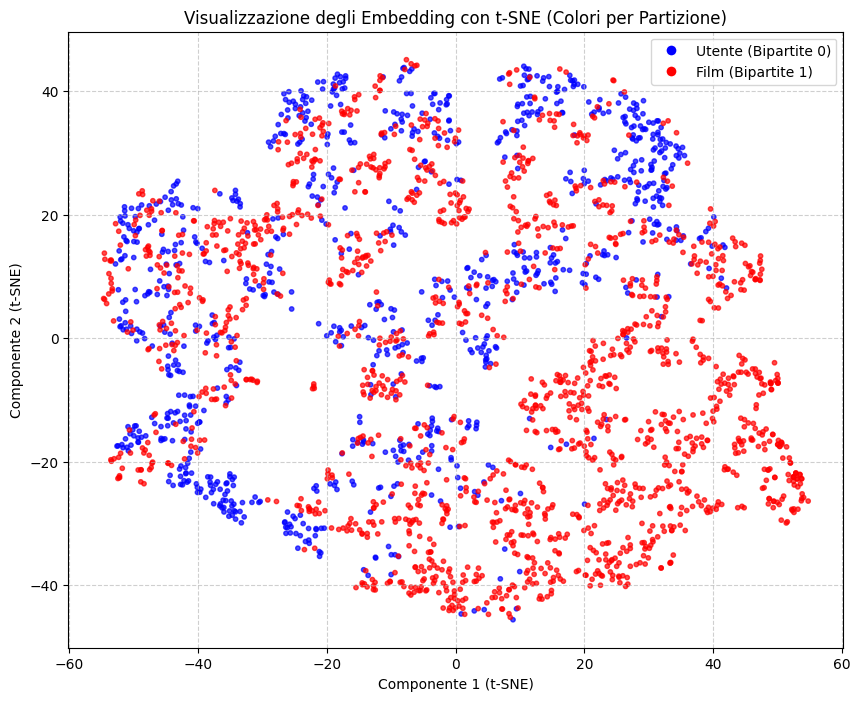

In [146]:
embeddings_np = node_embeddings.cpu().numpy()


tsne = TSNE(n_components=2, perplexity=30, random_state=42)


embeddings_2d_tsne = tsne.fit_transform(embeddings_np)

try:
    # Colori basati sulla partizione: 0 per Utente, 1 per Film
    colors = []
    for i in range(len(embeddings_np)):
        original_node_id = idx_to_node[i]
        node_type = B.nodes[original_node_id]['bipartite']
        colors.append('blue' if node_type == 0 else 'red') # Blu per Utenti, Rosso per Film

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], 
                          c=colors, s=10, alpha=0.7)
    plt.title('Visualizzazione degli Embedding con t-SNE (Colori per Partizione)')
    plt.xlabel('Componente 1 (t-SNE)')
    plt.ylabel('Componente 2 (t-SNE)')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Crea una legenda manuale
    handles = [plt.Line2D([0], [0], marker='o', color='w', label='Utente (Bipartite 0)', 
                          markerfacecolor='blue', markersize=8),
               plt.Line2D([0], [0], marker='o', color='w', label='Film (Bipartite 1)', 
                          markerfacecolor='red', markersize=8)]
    plt.legend(handles=handles)
    plt.show()

except NameError:
    print("\nPer plottare con colori per partizione, assicurati che 'B' e 'idx_to_node' siano definiti.")
except Exception as e:
    print(f"\nErrore durante il plotting con colori per partizione (t-SNE): {e}")